In [1]:
from ddganAE.models import AAE, AAE_combined_loss, CAE, SVDAE
from ddganAE.architectures import *
from ddganAE.preprocessing import convert_2d
from keras.regularizers import l2
from ddganAE.utils import calc_pod
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# POD

This can be used to check against, we try to find models that perform better than POD. Let's use 10 POD components, i.e. 10 latent space dimensions.

In [2]:
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

# Data normalization
layer = preprocessing.Normalization(axis=None)
layer.adapt(snapshots_grids)

snapshots_grids = layer(snapshots_grids).numpy()

coeffs, R, s = calc_pod(snapshots_grids, nPOD=10)

In [3]:
R.shape

(4620, 10)

In [4]:
np.array(coeffs).shape

(4, 10, 2000)

In [6]:
s

array([5373.57223418, 1704.145879  , 1624.78372004, 1014.78008417,
        683.57342375,  629.83693702,  246.99728417,  230.89939438,
        223.44909246,  205.73381807])

In [3]:
# Reconstruct the first subgrid
recon = R @ coeffs[0]
print(recon, '\n',
      snapshots_grids[0, :, :])

np.allclose(recon, snapshots_grids[0, :, :], atol=1e-1)

[[-0.06574968  0.889425    0.88533004 ...  0.87480204  0.87580177
   0.87668235]
 [-0.06609004  0.90028732  0.89612372 ...  0.87883499  0.88167603
   0.88347498]
 [-0.06642842  0.91079298  0.9066454  ...  0.88245219  0.88744083
   0.89054423]
 ...
 [ 0.00203796 -0.91469858 -0.9098966  ... -0.84175103 -0.84852721
  -0.85643904]
 [ 0.01400781 -0.90751887 -0.90274946 ... -0.86341723 -0.86687382
  -0.87072066]
 [ 0.02451946 -0.89983887 -0.8949772  ... -0.87770123 -0.87856547
  -0.87918458]] 
 [[-0.8800349   0.868157    0.86859614 ...  0.86862653  0.86862624
   0.8686259 ]
 [-0.8800349   0.86855257  0.8686306  ...  0.86863226  0.8686321
   0.8686319 ]
 [-0.8800349   0.8684343   0.8686299  ...  0.8686306   0.8686304
   0.86863023]
 ...
 [-0.8800349  -0.8815101  -0.8816277  ... -0.84021616 -0.85250354
  -0.8658067 ]
 [-0.8800349  -0.88055855 -0.8804519  ... -0.86244816 -0.86827886
  -0.8745808 ]
 [-0.8800349  -0.88086855 -0.88045865 ... -0.8771531  -0.87748325
  -0.8778174 ]]


False

In [4]:
print(recon[:, 1],snapshots_grids[0, :, 1])

[ 0.889425    0.90028732  0.91079298 ... -0.91469858 -0.90751887
 -0.89983887] [ 0.868157    0.86855257  0.8684343  ... -0.8815101  -0.88055855
 -0.88086855]


In [5]:
# Calculate MSE
mean = 0
for j in range(4):
    recon = R @ coeffs[j]
    for i in range(2000):
        mean += tf.keras.losses.MSE(recon[:, i], snapshots_grids[j, :, i]).numpy()/8000
    
print(mean)

0.011914519353747969


In [15]:
print(snapshots_grids.shape, recon.shape)

shape = (4, 4620, 2000)

reconstructed = np.zeros((4, 4620, 2000))

for i in range(4):
    reconstructed[i, :, :] = R @ coeffs[i]

# Undo normalization
reconstructed = (reconstructed * np.sqrt(layer.variance.numpy()) + layer.mean.numpy())

(4, 4620, 2000) (4620, 2000)


In [16]:
reconstructed

array([[[ 1.81607654e-02,  3.94637471e-02,  3.93724185e-02, ...,
          3.91376155e-02,  3.91599121e-02,  3.91795515e-02],
        [ 1.81531745e-02,  3.97060062e-02,  3.96131467e-02, ...,
          3.92275612e-02,  3.92909241e-02,  3.93310456e-02],
        [ 1.81456276e-02,  3.99403110e-02,  3.98478086e-02, ...,
          3.93082345e-02,  3.94194947e-02,  3.94887089e-02],
        ...,
        [ 1.96726135e-02, -7.73093639e-04, -6.65996531e-04, ...,
          8.53834140e-04,  7.02706944e-04,  5.26251773e-04],
        [ 1.99395735e-02, -6.12966783e-04, -5.06596021e-04, ...,
          3.70619355e-04,  2.93527936e-04,  2.07732982e-04],
        [ 2.01740116e-02, -4.41681882e-04, -3.33253625e-04, ...,
          5.20472815e-05,  3.27724020e-05,  1.89647074e-05]],

       [[ 1.81607654e-02,  3.84570907e-02,  3.84571089e-02, ...,
          4.12372153e-02,  4.17050131e-02,  4.21056498e-02],
        [ 1.81531745e-02,  3.88012879e-02,  3.88012987e-02, ...,
          4.19343580e-02,  4.24432344e

In [17]:
reconstructed = convert_2d(reconstructed, (55, 42, 2), 2000)
reconstructed = np.array(reconstructed).swapaxes(1, 4)

np.save("reconstruction_pod_10coeffs.npy", reconstructed)

# Convolutional Autoencoder

### Our dataset (55x42)

In [2]:
# Data processing
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

input_shape = (55, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 2000)
snapshots = np.array(snapshots).reshape(8000, *input_shape)
snapshots.shape

from sklearn.model_selection import train_test_split

# Data normalization
layer = preprocessing.Normalization()
layer.adapt(snapshots)

x_train, x_val = train_test_split(snapshots, test_size=0.1)
x_train = layer(x_train)
x_val = layer(x_val)

In [3]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.9, beta_2=0.999)

#encoder, decoder = build_densest_omata_encoder_decoder(input_shape, 10, initializer, info=True, act='elu', dense_act='relu')

# Use these lines to load a previous model
encoder = tf.keras.models.load_model("saved_model_cae/encoder") 
decoder = tf.keras.models.load_model("saved_model_cae/decoder")

cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

KeyboardInterrupt: 

In [4]:
cae.train(x_train, 100, val_data=x_val, batch_size=64)

KeyboardInterrupt: 

In [7]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
cae.encoder.save('saved_model/encoder')
cae.decoder.save('saved_model/decoder')

INFO:tensorflow:Assets written to: saved_model/encoder/assets
INFO:tensorflow:Assets written to: saved_model/decoder/assets


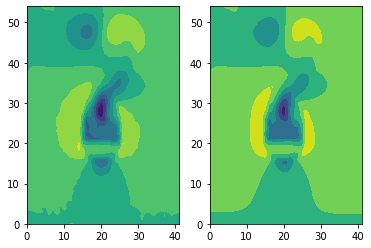

In [9]:
grid = x_val[250:251, :, :, :]
res = cae.predict(grid)

fig, ax = plt.subplots(1,2)
ax[0].contourf(res[0,:,:,0])
ax[1].contourf(grid[0, :, :, 0])

#### Prepare output to reconstruct to .vtu file 

In [5]:
snapshots = layer(snapshots)
res = cae.predict(snapshots)

In [6]:
# Undo normalization
res = (res * np.sqrt(layer.variance.numpy()) + layer.mean.numpy())

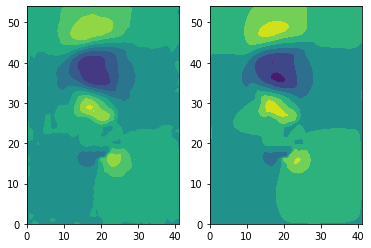

In [8]:
fig, ax = plt.subplots(1,2)
ax[0].contourf(res[92,:,:,1])
ax[1].contourf(snapshots[92, :, :, 1])

In [7]:
# Reshape to how reconstruction legacy code wants it
reconstruction = res.reshape((4, 2000, 55, 42, 2)).swapaxes(1, 4)
np.save("cae_reconstruction.npy", reconstruction)

# Adversarial Autoencoder

In [2]:
# Data processing
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

input_shape = (55, 42, 2)
snapshots = convert_2d(snapshots_grids, input_shape, 2000)
snapshots = np.array(snapshots).reshape(8000, *input_shape)
snapshots.shape

from sklearn.model_selection import train_test_split

# Data normalization
layer = preprocessing.Normalization()
layer.adapt(snapshots)

x_train, x_val = train_test_split(snapshots, test_size=0.1)
x_train = layer(x_train)
x_val = layer(x_val)

In [3]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00001, beta_1=0.9, beta_2=0.999)

encoder, decoder = build_denser_omata_encoder_decoder(input_shape, 10, initializer, info=True)
discriminator = build_custom_discriminator(10, initializer, info=True)

#encoder = tf.keras.models.load_model("saved_model_aae/encoder")
#decoder = tf.keras.models.load_model("saved_model_aae/decoder")
#discriminator = tf.keras.models.load_model("saved_model_aae/discriminator")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 42, 32)        1632      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5376)              0

### Separate losses

In [4]:
aae = AAE(encoder, decoder, discriminator, optimizer)
aae.compile(input_shape)

In [ ]:
aae.train(x_train, 100, val_data=x_val)

### Combined losses

In [4]:
aae = AAE_combined_loss(encoder, decoder, discriminator, optimizer)
aae.compile(input_shape)

In [5]:
aae.train(x_train, 100, val_data=x_val)

KeyboardInterrupt: 

#### Prepare output to reconstruct to .vtu file 

In [6]:
snapshots = layer(snapshots)
res = aae.autoencoder.predict(snapshots)

In [7]:
# Undo normalization
res = (res * np.sqrt(layer.variance.numpy()) + layer.mean.numpy())

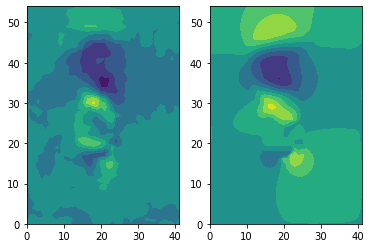

In [8]:
fig, ax = plt.subplots(1,2)
ax[0].contourf(res[92,:,:,1])
ax[1].contourf(snapshots[92, :, :, 1])

In [9]:
# Reshape to how reconstruction legacy code wants it
reconstruction = res.reshape((4, 2000, 55, 42, 2)).swapaxes(1, 4)
np.save("aae_reconstruction.npy", reconstruction)

# SVD Autoencoder

In [2]:
# Data processing
snapshots_grids = np.load("./../submodules/DD-GAN/data/processed/snaphsots_field_Velocity_new_4_2000steps.npy")

# Data normalization
layer = preprocessing.Normalization(axis=None)
layer.adapt(snapshots_grids)

snapshots_grids = snapshots_grids.swapaxes(0, 2)

batch_size = 32

In [3]:
x_train, x_val = train_test_split(snapshots_grids, test_size=0.1 )
x_train = layer(x_train).numpy().swapaxes(0, 2)
x_val = layer(x_val).numpy().swapaxes(0, 2)

In [4]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.SGD(lr=0.00005, momentum=0.98)

dense_encoder = build_slimmer_dense_encoder(10, initializer, info=False,  dropout=0.3, act="elu")
dense_decoder = build_slimmer_dense_decoder(100, 10, initializer, info=False,  dropout=0.3, act="elu")

#dense_encoder = tf.keras.models.load_model("saved_model_svdae/encoder")
#dense_decoder = tf.keras.models.load_model("saved_model_svdae/decoder")

In [5]:
encoder, decoder = build_smaller_vinicius_encoder_decoder(100, 10, initializer, info=True, reg=1e-4, dropout=0.3)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 64)         

In [6]:
svdae = SVDAE(encoder, decoder, optimizer)
svdae.compile(100, weight_loss=False)

# Only set this when loading in the model
#svdae.R = np.load("R_svdae.npy")

In [7]:
svdae.train(x_train, 200, val_data=x_val, batch_size=batch_size)

KeyboardInterrupt: 

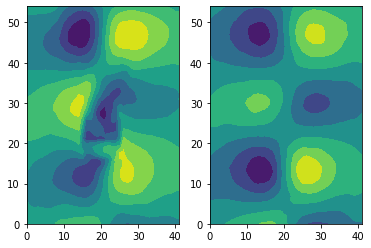

In [8]:
original = x_val[2, :, 30]

result = svdae.predict_single(original)
result = np.expand_dims(result,(0,2))
input_shape = (55, 42, 2)
result = convert_2d(result, input_shape, 1)


original = np.expand_dims(original,(0,2))
input_shape = (55, 42, 2)
original = convert_2d(original, input_shape, 1)


fig, ax = plt.subplots(1,2)
ax[0].contourf(result[0][0, :, :, 0])
ax[1].contourf(original[0][0, :, :, 0])

In [67]:
#np.load("aae_reconstruction.npy").shape

(4, 2, 55, 42, 2000)

#### Predicting a set of output grids for the svd autoencoder

In [9]:
snapshots = layer(snapshots_grids).numpy().swapaxes(0, 2)

In [10]:
snapshots_grids.shape

(2000, 4620, 4)

In [11]:
np.moveaxis(np.array(result).reshape(55, 42, 2), 2, 0).shape

(2, 55, 42)

In [12]:
output = np.zeros((4, 2, 55, 42, 2000))
loss = 0
for i in range(snapshots.shape[0]):
    for j in range(snapshots.shape[2]):
        original = snapshots[i, :, j]
        result = svdae.predict_single(original)
        loss += tf.keras.losses.MSE(original, result)
        result = (result * np.sqrt(layer.variance.numpy()) + layer.mean.numpy())
        result = np.expand_dims(result,(0,2))
        input_shape = (55, 42, 2)
        result = convert_2d(result, input_shape, 1)
        output[i, :, :, :, j] = np.moveaxis(np.array(result).reshape(55, 42, 2), 2, 0)
        if j % 100 == 0:
            print(j)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


KeyboardInterrupt: 

In [13]:
loss.numpy()/8000

0.03851393213031565

In [86]:
output.shape

(4, 2, 55, 42, 2000)

In [125]:
np.save("svdae_reconstruction.npy", output)

In [3]:
np.load("cae_reconstruction.npy").shape

(4, 2, 55, 42, 2000)

In [90]:
input_shape = (55, 42, 2)
result = convert_2d(snapshots, input_shape, 2000)

In [92]:
snapshots = np.array(result)

In [108]:
snapshots_reshaped = np.moveaxis(np.moveaxis(snapshots, 1, 4), 3, 1)
snapshots_reshaped = snapshots_reshaped.reshape(2000, 4620, 4)

In [111]:
output_reshaped = output.reshape(2000, 4620, 4)

In [115]:
tf.keras.losses.MSE(layer(snapshots_reshaped), layer(output_reshaped))

1927.4203

In [101]:
# Calculate MSE
mean = 0
for j in range(4):
    for i in range(1000):
        mean += tf.keras.losses.MSE(snapshots_reshaped[j, :, :, :, i], output[j, :, :, :, i]).numpy()/4000
    
print(mean)

[[0.77373479 0.77388099 0.77370624 0.77360166 0.77323434 0.77314297
  0.7736847  0.77379379 0.77376172 0.77527252 0.77765292 0.78110186
  0.78745405 0.79855139 0.8190091  0.8583387  0.8968064  0.94850024
  1.02528308 1.04314032 1.00918348 1.01333907 1.00710268 1.00057693
  1.00064759 0.99805419 1.0044451  1.02777026 1.03302593 1.01203422
  0.97464399 0.93564913 0.89919552 0.87032889 0.84840289 0.8338368
  0.82400089 0.81521355 0.80840768 0.8034596  0.80064139 0.79754713
  0.7960436  0.79585597 0.79455834 0.79360526 0.79287399 0.79265459
  0.79288669 0.79333561 0.79347566 0.79309157 0.79312558 0.79293838
  0.79448396]
 [1.00944764 1.00997406 1.00869407 1.00846435 1.00651601 1.00624211
  1.00846726 1.00555166 1.00560556 1.0089055  1.01196617 1.01587895
  1.0240375  1.03879196 1.0595499  1.09647458 1.11940032 1.18278482
  1.08313785 0.99268448 0.95989141 0.9680874  0.97135087 0.97562847
  0.97759488 0.99854303 1.02286722 1.01646342 1.0195895  1.04296482
  1.06790045 1.08853808 1.0981992  

In [105]:
np.mean(tf.keras.losses.MSE(snapshots_reshaped, output))

0.958719368381383

In [124]:
!mkdir -p saved_model
svdae.encoder.save('saved_model_svdae/encoder')
svdae.decoder.save('saved_model_svdae/decoder')
np.save('saved_model_svdae/R.npy', svdae.R)

INFO:tensorflow:Assets written to: saved_model_svdae/encoder/assets
INFO:tensorflow:Assets written to: saved_model_svdae/decoder/assets


In [ ]:
u, s, v 